In [ ]:
# 📌 데이터 준비 과정 (사전 실행 완료된 단계 요약)

이 Notebook에서 사용되는 데이터(`comp_sentences.csv`)는 아래 과정들을
이미 Google Colab에서 사전에 실행하여 준비해 둔 상태입니다.
따라서 이 Notebook에서는 데이터 로드 및 분석(EDA)부터 시작합니다.

---

## 1. AI Hub 한국어 대학 강의 데이터(TL.zip) 준비
- AI Hub에서 제공하는 "한국어 대학 강의 데이터"의 라벨링 ZIP 파일(TL.zip.part0, TL.zip.part1)을 다운로드했습니다.
- 두 분할 파일을 병합하여 완전한 `TL.zip` 파일을 생성했습니다.

```bash
# (사전 실행) 로컬 또는 터미널에서 수행
cat TL.zip.part0 TL.zip.part1 > TL.zip

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/ML_Project

In [ ]:
import zipfile, os

prefix = "eng/comp/"
zip_path = "TL.zip"
extract_to = "TL_comp"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    for info in z.infolist():
        if info.filename.startswith(prefix):
            z.extract(info, extract_to)

print("컴퓨터통신(eng/comp) 데이터 추출 완료")

In [ ]:
import json
import pandas as pd
import glob
import os

base_dir = "TL_comp"
files = glob.glob(os.path.join(base_dir, "eng/comp/*/*.json"))

rows = []
for f in files:
    with open(f, "r", encoding="utf-8") as jf:
        data = json.load(jf)
        text = data["06_transcription"]["1_text"]
        lecture_id = data["02_srcinfo"]["1_id"]
        major = "comp"
        rows.append([lecture_id, major, text])

df = pd.DataFrame(rows, columns=["lecture_id", "major", "sentence"])
df.to_csv("comp_sentences.csv", index=False)

In [ ]:
comp_sentences.csv
TL_comp/eng/comp/*.json

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/ML_Project

Mounted at /content/drive
/content/drive/MyDrive/ML_Project


In [2]:
import pandas as pd
df = pd.read_csv("comp_sentences.csv")
df.head()

,lecture_id,major,sentence
0,C02199,comp,자연 (log)/(로그)를 취한 겁니다.
1,C02199,comp,이렇게 하면 이렇게 된다.
2,C02199,comp,1 0 1 1 0 이렇게 되니까 되니까 띠 모양 있는 부분만 남기고 다 죽이는 모든...
3,C02199,comp,통과시키는 걸 볼 수 있겠죠?
4,C02199,comp,이제 구성은 이렇게 되어 있고요.


In [3]:
df.info()
df.isnull().sum()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122144 entries, 0 to 122143
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   lecture_id  122144 non-null  object
 1   major       122144 non-null  object
 2   sentence    122144 non-null  object
dtypes: object(3)
memory usage: 2.8+ MB


np.int64(2909)

In [4]:
df["length"] = df["sentence"].astype(str).apply(len)
df["length"].describe()

,length
count,122144.000000
mean,46.917696
std,39.882380
min,1.000000
25%,20.000000
50%,36.000000
75%,62.000000
max,567.000000


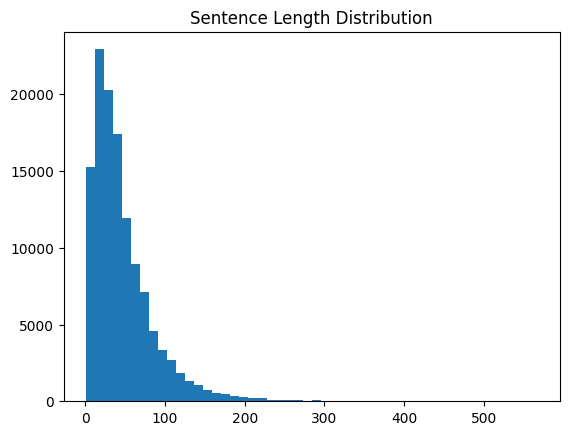

In [5]:
import matplotlib.pyplot as plt

plt.hist(df["length"], bins=50)
plt.title("Sentence Length Distribution")
plt.show()

In [6]:
from collections import Counter
import re

def tokenize(s):
    return re.findall(r"[가-힣A-Za-z0-9]+", s)

words = []
for s in df["sentence"]:
    words += tokenize(str(s))

Counter(words).most_common(20)

[('이', 19574),
 ('그래서', 15183),
 ('이제', 14305),
 ('어', 13986),
 ('자', 12975),
 ('이렇게', 12867),
 ('그', 12844),
 ('우리가', 11534),
 ('수', 10540),
 ('이런', 10205),
 ('있는', 9668),
 ('뭐', 9353),
 ('하는', 5731),
 ('때', 5726),
 ('지금', 5606),
 ('그리고', 5503),
 ('있습니다', 5445),
 ('요', 5327),
 ('그러면', 5249),
 ('어떤', 4876)]

In [ ]:
# 분석 요약
- 총 문장 수: XXXX개
- 결측치 없음
- 문장 평균 길이 XX자
- 길이 분포는 XX~XX자에 집중
- 가장 많이 등장하는 단어: ~~~, ~~~, ~~~
- Assignment 5에서 TF-IDF 기반 분류 모델에 적합한 데이터임